In [196]:
%config Completer.use_jedi = False
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from typing import List
width = 800
height = 600
import pandas as pd
import multiprocessing
import json
from collections import namedtuple

In [240]:
AnalysisData = namedtuple("AnalysisData", ["input", "num_threads", "iter", "forward_pass_time", "backward_pass_time", "original_size", "compressed_size", "bytes_saved", "percent_of_original", "total_time"])

def amdahl(su):
    s = multiprocessing.cpu_count()*2*2
    p = -1
    p = s * (1 - (1 / su)) / (s - 1)
    print(f"Calculating Amdah. (su: {su}), (s: {s}), (p: {p})")
    return p

def calcspeedup(sequential_avg, parallel_avg):
    return sequential_avg / parallel_avg


def analysisjsonToDF(infilejson: str) -> pd.DataFrame:
    with open(infilejson, 'r') as f:
        dat = json.load(f)
    
    analysisdats = []
    for d in dat:
        lines = d[3].split('\n')
        analysisdats.append(AnalysisData(
            d[0], #input
            d[1], # num_threads
            d[2], #iter
            lines[2].split()[0], # forward pass time
            lines[5].split()[0], # backward pass time
            # lines[9].split()[-1], # worked?
            int(''.join(filter(str.isdigit, lines[10].split()[-1]))), # original size
            int(''.join(filter(str.isdigit, lines[11].split()[-1]))), # compressed size
            int(lines[12].split()[-1]) if int(lines[12].split()[-1]) < 100000000000000000 else -1, # bytes saved
            lines[13].split()[-1], # percent of original 
            float(lines[15].split()[0]))) # total time
    return pd.DataFrame(data=analysisdats)

def calcamdahlforinput(df: pd.DataFrame, inputfn: str) -> List[float]:
    dfoi = df[df.input == inputfn]
    avgs = []
    for num_thread in set(dfoi.num_threads):
        avgs.append((num_thread, dfoi[dfoi.num_threads == num_thread].total_time.mean()))

    amdahls_list = []
    for i, avg in enumerate(avgs):
        _su = 1
        _p = 0
        if i != 0:
            _su = calcspeedup(avgs[0][1], avg[1])
            _p = amdahl(_su)
        amdahls_list.append((avg[0], _su, _p, avg[1]))
    return amdahls_list

def DataFrameToTable(df: pd.DataFrame):
    s = ""
    for header in list(df.columns.values):
        s += f"| {header} "
    s += "|\n"
    print(s)
    s = ""
    for header in list(df.columns.values):
        s += "| --- "
    s += "|\n"
    print(s)
    for _, row in df.iterrows():
        s = ""
        for item in list(row):
            s += f"| {item} "
        s += "|\n"
        print(s)
        

In [252]:
evaldf = analysisjsonToDF('../evalres25k.json')
print(set(evaldf.input))

{'tests/E.coli', 'tests/lorem.txt', 'tests/ban.txt', 'tests/bible.txt', 'tests/onemeglorem.txt'}


In [253]:
infile = 'tests/onemeglorem.txt'
evaldf[evaldf.num_threads == 1]

,input,num_threads,iter,forward_pass_time,backward_pass_time,original_size,compressed_size,bytes_saved,percent_of_original,total_time
0,tests/ban.txt,1,1,0.000313,0.004757,30,22,8,73.33%,0.005228
1,tests/ban.txt,1,2,0.000575,0.000128,30,22,8,73.33%,0.000845
2,tests/ban.txt,1,3,0.000240,0.000184,30,22,8,73.33%,0.000927
18,tests/onemeglorem.txt,1,1,140.144931,23.629782,1048576,107090,941486,10.21%,163.776279
19,tests/onemeglorem.txt,1,2,140.902665,23.493357,1048576,107090,941486,10.21%,164.397662
20,tests/onemeglorem.txt,1,3,140.672769,23.488458,1048576,107090,941486,10.21%,164.162789
36,tests/lorem.txt,1,1,382.474708,63.455019,3000635,305749,2694886,10.19%,445.938324
37,tests/lorem.txt,1,2,380.551198,63.435765,3000635,305749,2694886,10.19%,443.995741
38,tests/lorem.txt,1,3,382.483935,63.467176,3000635,305749,2694886,10.19%,445.960234
54,tests/bible.txt,1,1,520.169415,93.641238,4047392,1951539,2095853,48.22%,613.820880


Calculating Amdah. (su: 1.8231467240794303), (s: 32), (p: 0.4660622389786361)
Calculating Amdah. (su: 3.2518541983441005), (s: 32), (p: 0.7148213033471404)
Calculating Amdah. (su: 2.0363254004032494), (s: 32), (p: 0.5253361038551694)
Calculating Amdah. (su: 2.0939180229654974), (s: 32), (p: 0.5392788489047172)
Calculating Amdah. (su: 1.9513760956301167), (s: 32), (p: 0.5032682573601673)
(1, 1, 0, 918.1490736666666)
(2, 1.8231467240794303, 0.4660622389786361, 503.6067923333333)
(4, 3.2518541983441005, 0.7148213033471404, 282.3463223333333)
(8, 2.0363254004032494, 0.5253361038551694, 450.88524333333334)
(12, 2.0939180229654974, 0.5392788489047172, 438.4837723333333)
(16, 1.9513760956301167, 0.5032682573601673, 470.51364200000006)


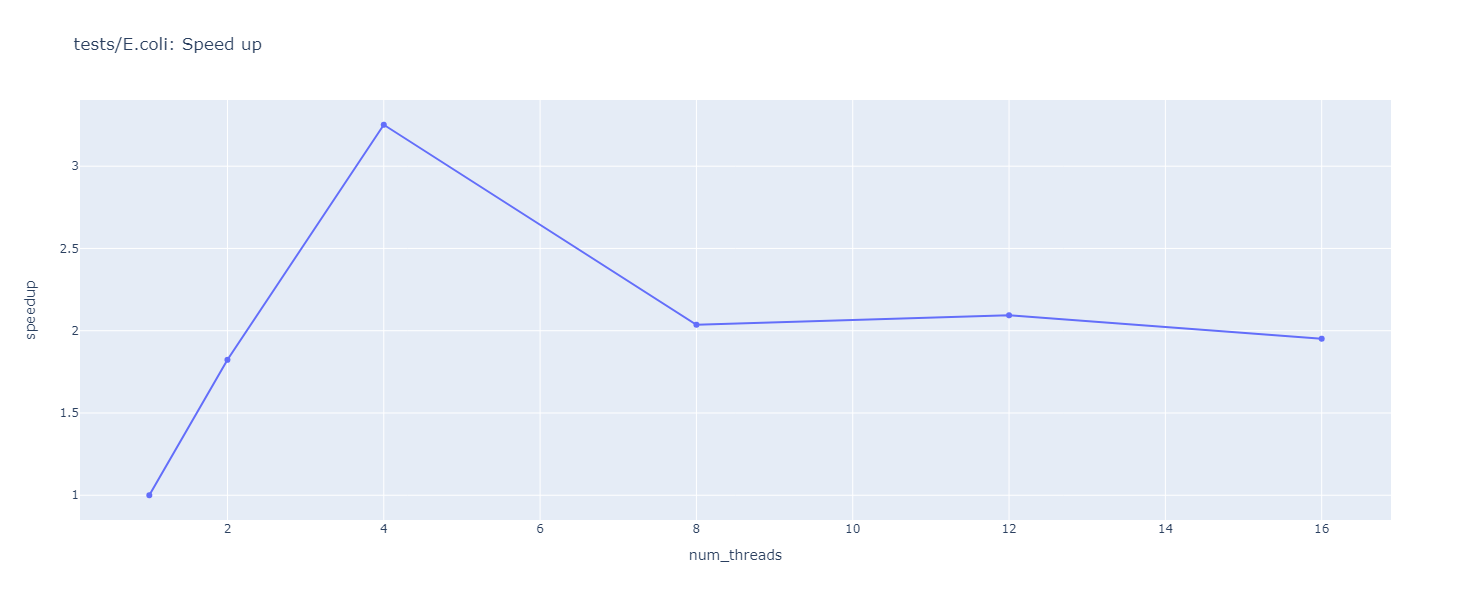

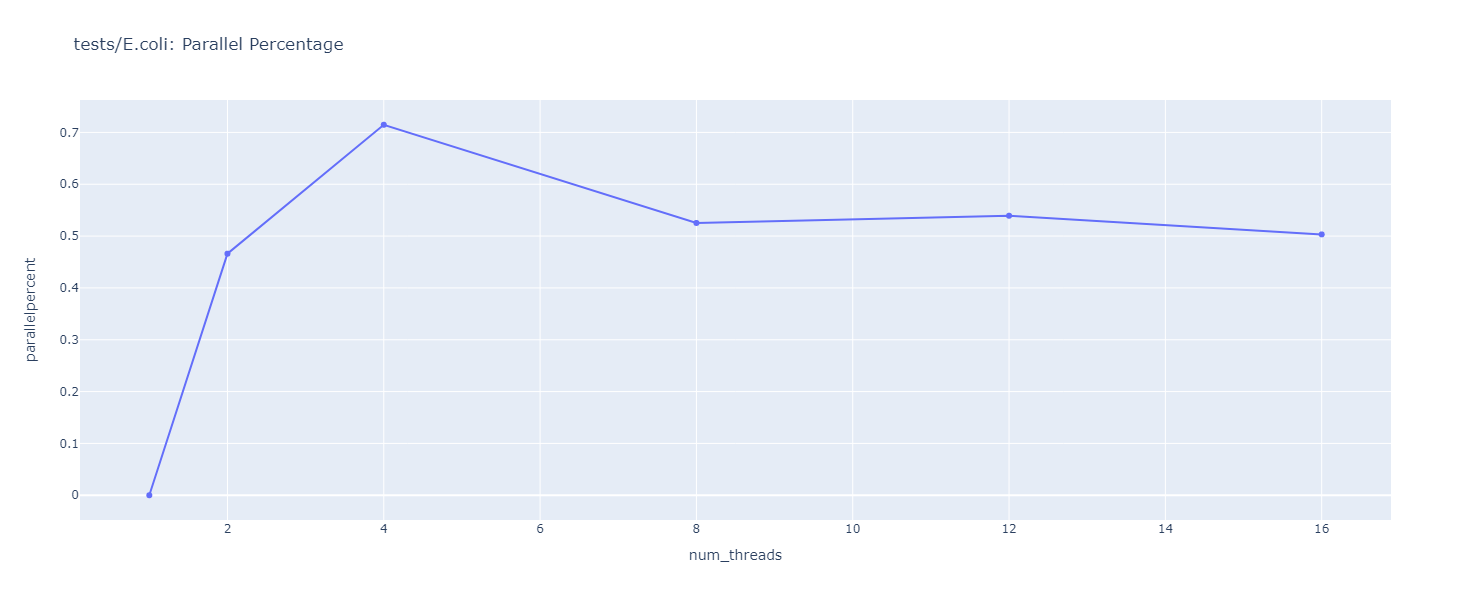

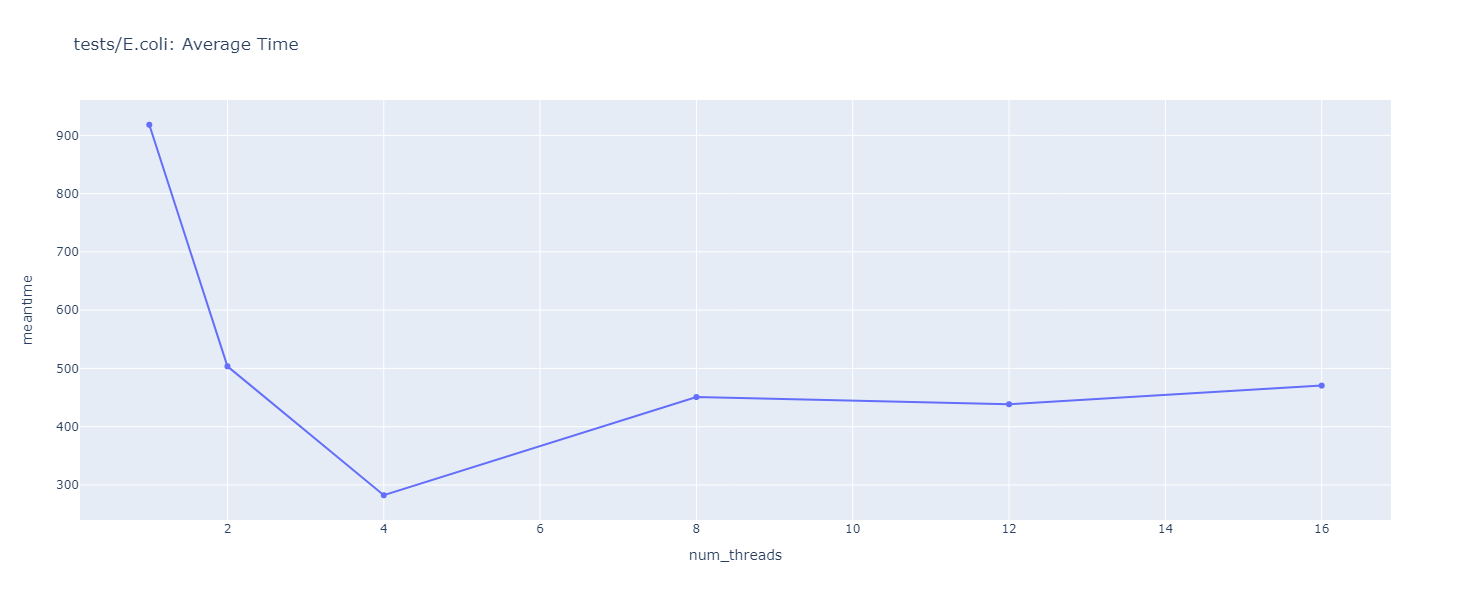

In [256]:
infile = 'tests/E.coli'
amdahs_ = calcamdahlforinput(evaldf, infile)
[print(n) for n in amdahs_]
amdf = pd.DataFrame(amdahs_, columns=["num_threads", "speedup", "parallelpercent", "meantime"])
fig = px.line(amdf, x="num_threads", y="speedup", height=height, width=width, title=f"{infile}: Speed up", markers=True)
fig.show()
fig.write_image("ecol_speedup.png")
fig = px.line(amdf, x="num_threads", y="parallelpercent", height=height, width=width, title=f"{infile}: Parallel Percentage", markers=True)
fig.show()
fig.write_image("ecol_Parallel_Percentage.png")
fig = px.line(amdf, x="num_threads", y="meantime", height=height, width=width, title=f"{infile}: Average Time", markers=True)
fig.show()
fig.write_image("ecol_Average_time.png")

The algorithm isn't doing the same amount of work, by the nature of dividing and conquering, its splitting up the domain and thus reducing the n^2 operation time significantly

```{c++}
string TextCompress::inplace_bwt(string inp) {
  string rets = inp;
  rets += STX;
  int n = rets.length();
  int i, p, r, s;
  unsigned char c;
  for (s = n - 3; s >= 0; s--) {
    c = rets[s];
    r = s;
    for (i = s + 1; rets[i] != STX; i++)
      if (rets[i] <= c) r++;
    p = i;
    while (i < n)
      if (rets[i++] < c) r++;
    rets[p] = c;
    for (i = s; i < r; i++) {
      rets[i] = rets[i + 1];
    }
    rets[r] = STX;
  }
  return rets;
}
```



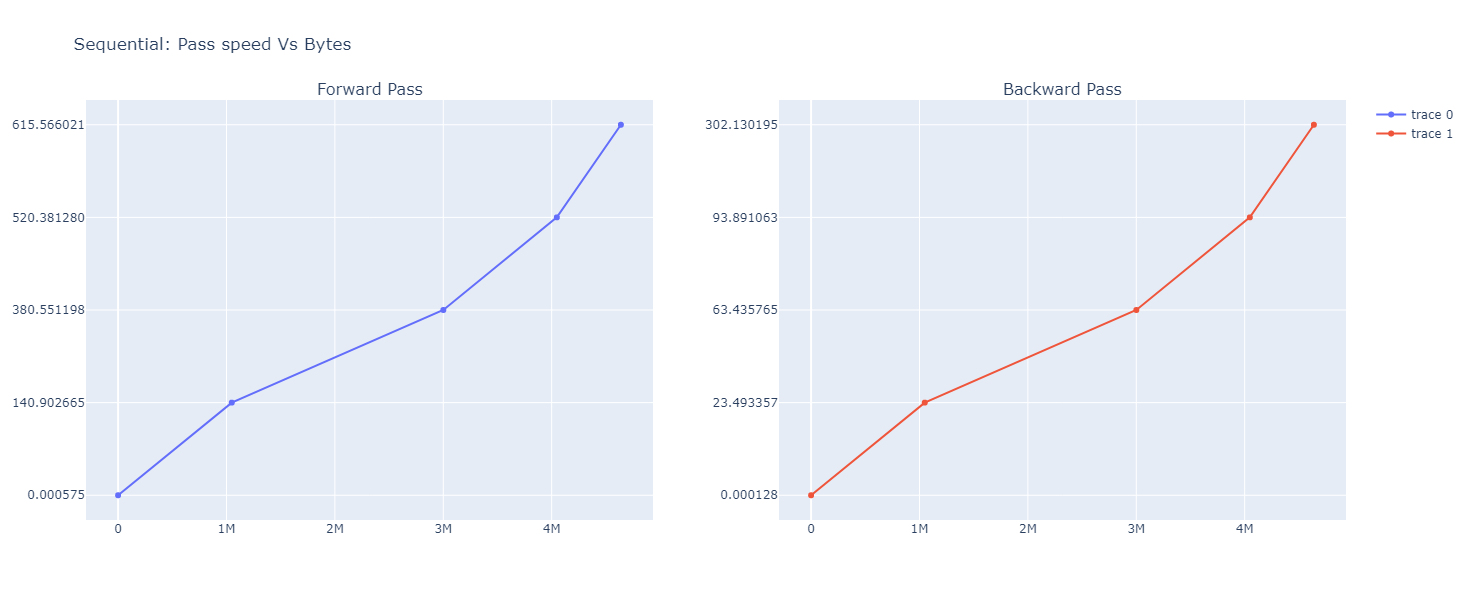

In [244]:
sdf = evaldf[(evaldf.num_threads == 1) & (evaldf.iter == 2)]
fig = make_subplots(rows=1, cols=2, subplot_titles=("Forward Pass", "Backward Pass"))
fig.add_trace(
    go.Scatter(x=sdf.original_size, y=sdf.forward_pass_time), row=1, col=1
)

fig.add_trace(
    go.Scatter(x=sdf.original_size, y=sdf.backward_pass_time), row=1, col=2
)

fig.update_layout(height=height, width=width, title_text = "Sequential: Pass speed Vs Bytes")
fig.show()
fig.write_image("sequential_timeblocks.png")
# fig = px.line(sdf, x=sdf.original_size, y=sdf.total_time, height=height, width=width, title="Sequential: Total time Vs Bytes", markers=True)
# fig.show()

From the figure above, we can see the work required to perform this operation on the total amount of bytes trends exponentially.

When we divide and conquer, we split the domain into discrete blocks such that if the problem scaled those blocks not reaching the same exponential time growth would aid in our speed up.



In [251]:
# fig = px.line(data_frame = evaldf[evaldf.num_threads == 1], x="original_size", y="total_time", height=height, width=width)
singles = evaldf[(evaldf.num_threads == 16) & (evaldf.iter == 3)]
DataFrameToTable(singles)

| input | num_threads | iter | forward_pass_time | backward_pass_time | original_size | compressed_size | bytes_saved | percent_of_original | total_time |

| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |

| tests/ban.txt | 16 | 3 | 0.000709 | 0.000442 | 30 | 81 | -1 | 270.00% | 0.00134 |

| tests/onemeglorem.txt | 16 | 3 | 8.741097 | 1.478218 | 1048576 | 363805 | 684771 | 34.70% | 10.221058 |

| tests/lorem.txt | 16 | 3 | 71.282284 | 12.905874 | 3000635 | 406937 | 2593698 | 13.56% | 84.194638 |

| tests/bible.txt | 16 | 3 | 139.779402 | 43.729499 | 4047392 | 1951539 | 2095853 | 48.22% | 183.524416 |

| tests/E.coli | 16 | 3 | 172.944976 | 297.530590 | 4638690 | 4234304 | 404386 | 91.28% | 470.492001 |



In [259]:
evaldf.total_time.sum()/60/60

5.149440173888888

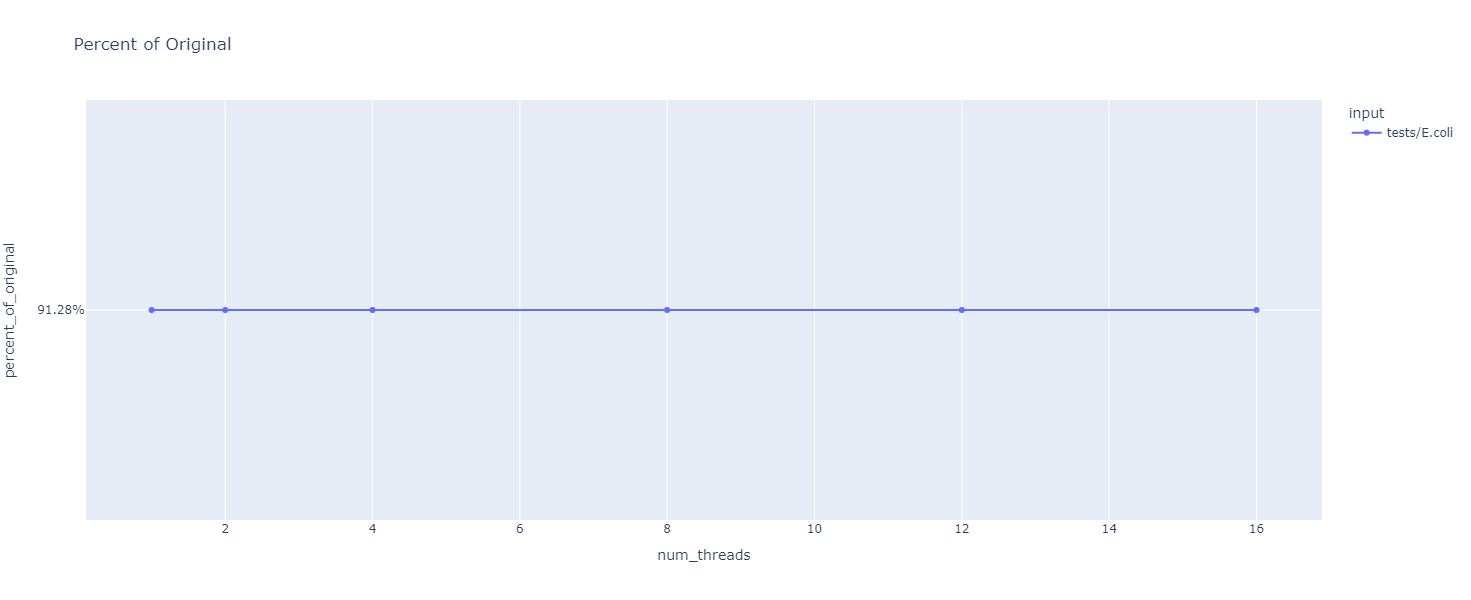

In [278]:
fig = px.line(evaldf[(evaldf.iter == 3) & (evaldf.input=="tests/E.coli")], x="num_threads", y="percent_of_original", height=height, width=width, color="input", title="Percent of Original", markers=True)
fig.show()
fig.write_image("ecol_percentorig.png")